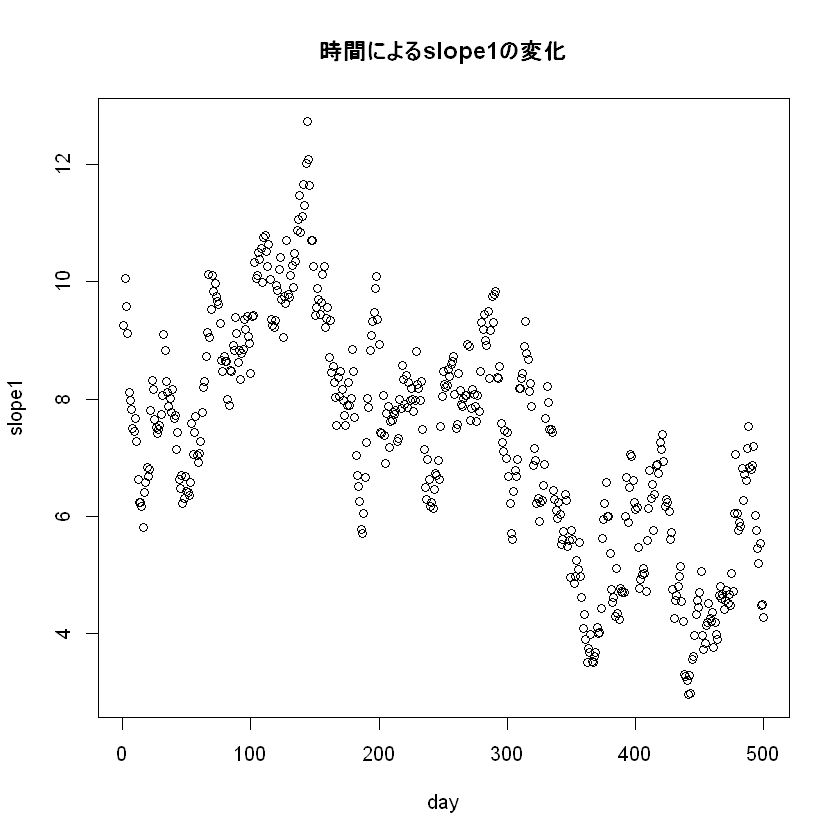

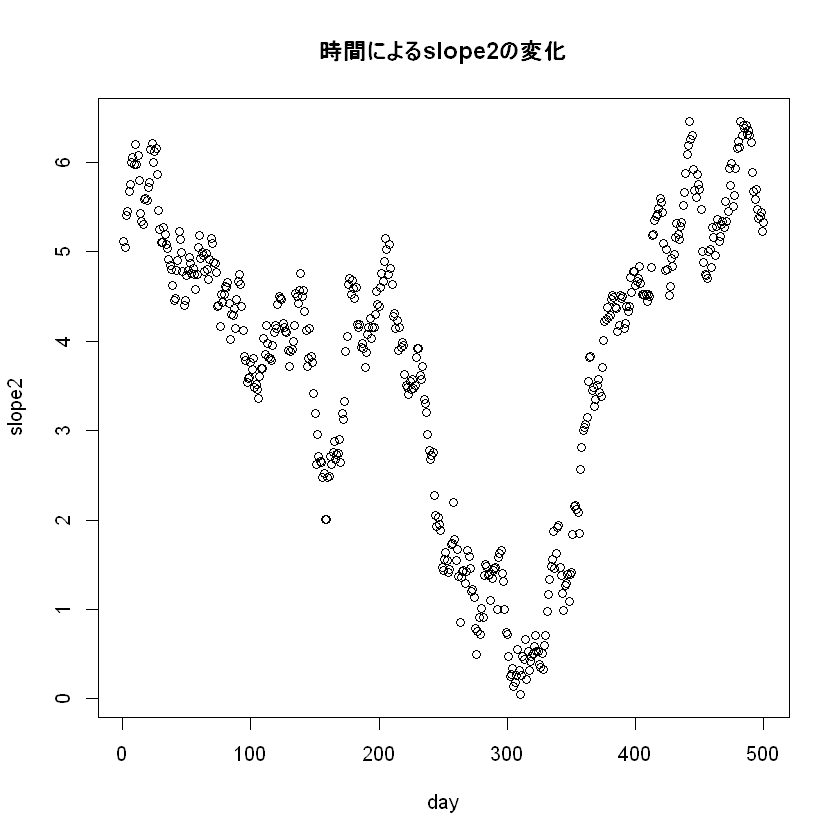

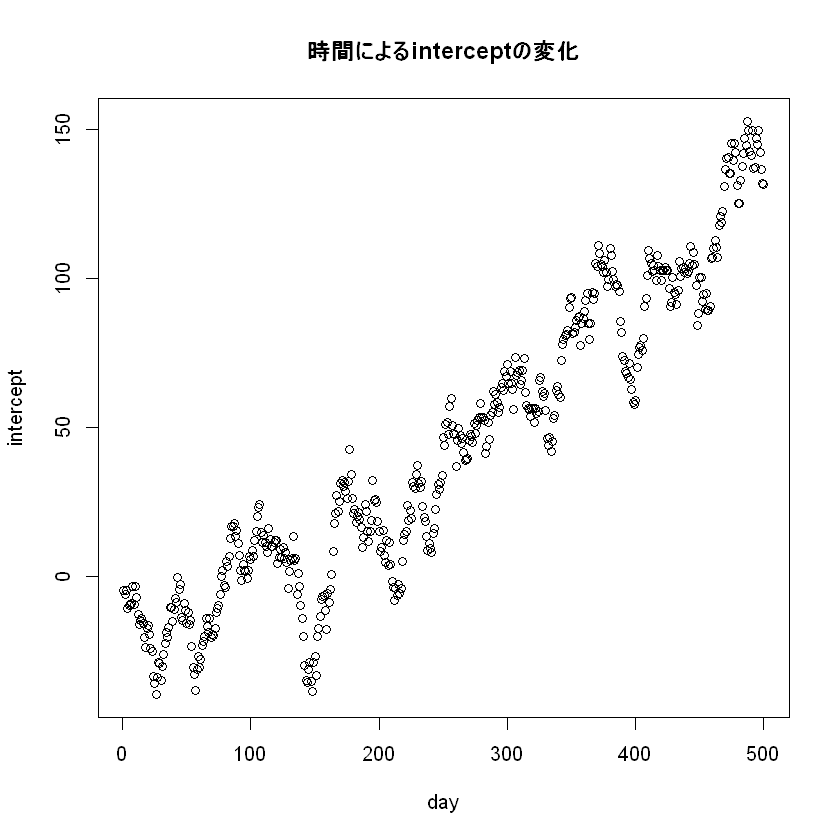

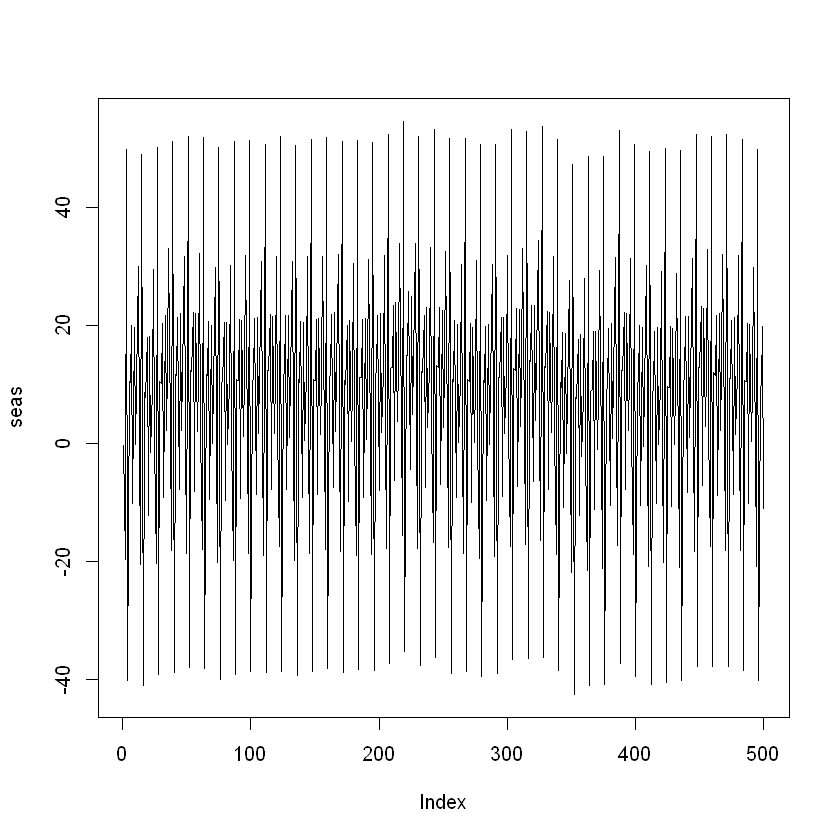

Warning message:
"package 'dlm' was built under R version 3.5.3"


$par
[1]  4.552578  2.811930 -1.485980 -2.730095 -7.675043

$value
[1] 1779.563

$counts
function gradient 
      43       23 

$convergence
[1] 0

$message
NULL

[1] 9.74046567 4.07946153 0.47568936 0.25536857 0.02154694

$FF
     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11] [,12] [,13] [,14]
[1,]    1    1    1    1    0    0    0    0    0     0     0     0     0     0

$V
         [,1]
[1,] 94.87667

$GG
      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11] [,12] [,13]
 [1,]    1    0    0    0    0    0    0    0    0     0     0     0     0
 [2,]    0    1    0    0    0    0    0    0    0     0     0     0     0
 [3,]    0    0    1    0    0    0    0    0    0     0     0     0     0
 [4,]    0    0    0   -1   -1   -1   -1   -1   -1    -1    -1    -1    -1
 [5,]    0    0    0    1    0    0    0    0    0     0     0     0     0
 [6,]    0    0    0    0    1    0    0    0    0     0     0     0     0
 [7,]    0    0    0    0    0    1    0    0    0     0     0     0     0
 [8,]    0    0    0    0    0    0    1    0    0     0     0     0     0
 [9,]    0    0    0    0    0    0    0    1    0     0     0     0     0
[10,]    0    0    0    0    0    0    0    0    

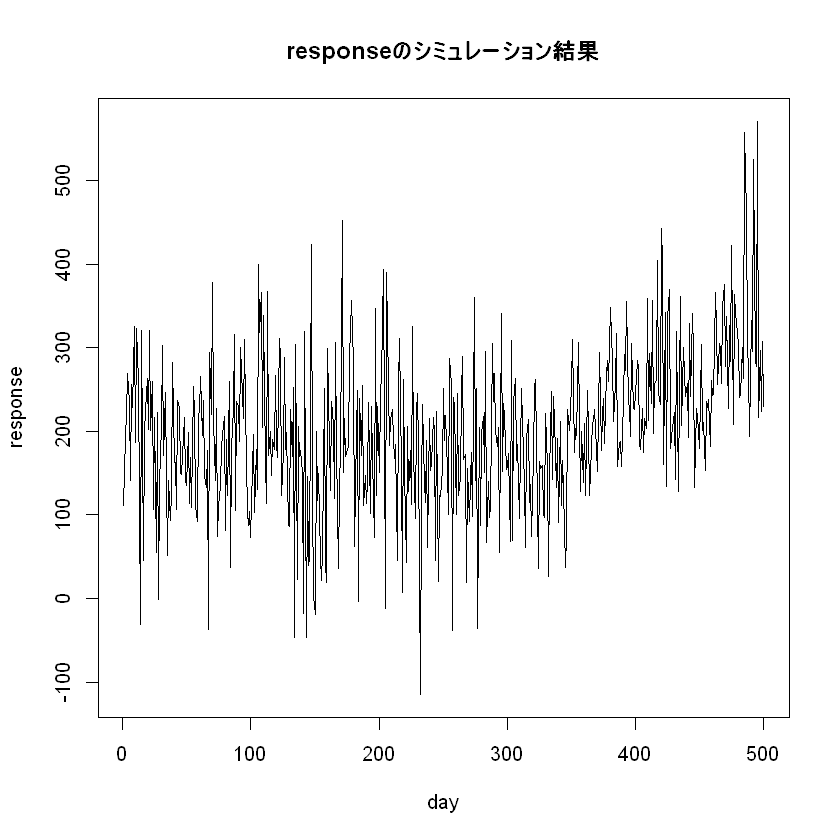

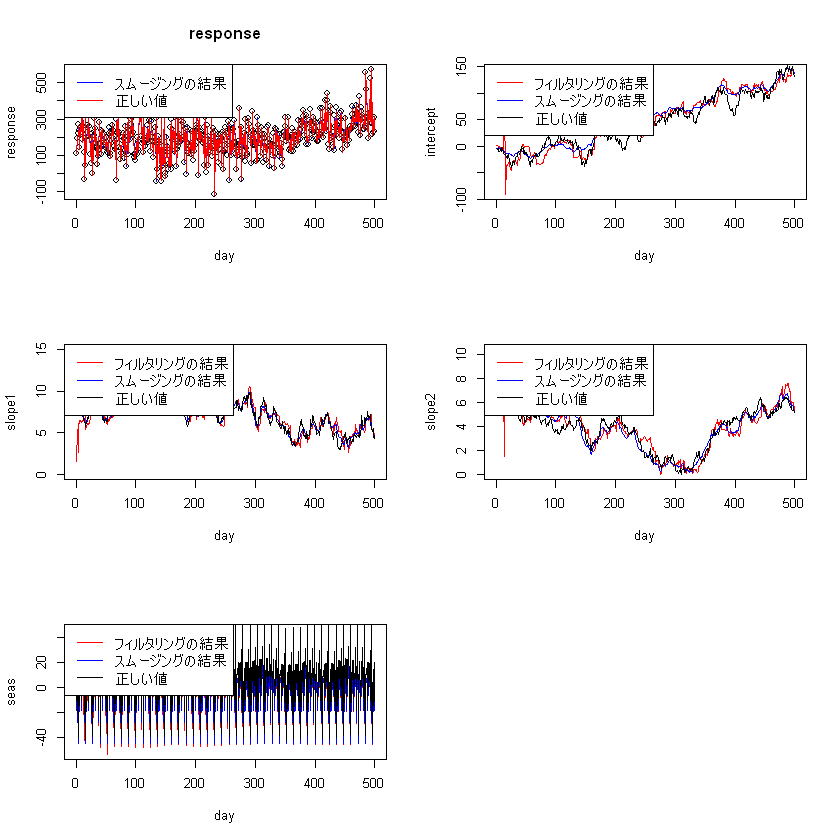

In [1]:
 

# パラメタの設定

# サンプルサイズ
N <- 500

# 観測誤差の標準偏差
observationErrorSD <- 10

# 切片の過程誤差の標準偏差
processErrorSD <- 5

# 係数1の過程誤差の標準偏差
coefErrorSD1 <- 0.5

# 係数2の過程誤差の標準偏差
coefErrorSD2 <- 0.2

# 季節性の過程誤差の標準偏差
seasErrorSD <- 0.4


### 各種シミュレーションデータの生成

# 説明変数をシミュレーションで作る
set.seed(1)
explanatory1 <- rnorm(n=N, mean=10, sd=10)

set.seed(2)
explanatory2 <- rnorm(n=N, mean=20, sd=5)

# slopeのシミュレーション
set.seed(12)
slope1 <- cumsum(rnorm(n=N, mean=0, sd=coefErrorSD1)) + 10
set.seed(13)
slope2 <- cumsum(rnorm(n=N, mean=0, sd=coefErrorSD2)) + 5

plot(slope1, main="時間によるslope1の変化", xlab="day")
plot(slope2, main="時間によるslope2の変化", xlab="day")

# interceptのシミュレーション
set.seed(3)
intercept <- cumsum(rnorm(n=N, mean=0, sd=processErrorSD))

plot(intercept, main="時間によるinterceptの変化", xlab="day")

#季節性のシミュレーション
set.seed(5)
seas<-rep(c(0,-2,5,-4,1,1,2,-1,2,0,1,3)*10,length=500)+cumsum(rnorm(n=N,mean=0,sd=seasErrorSD))
plot(seas,type="l")


# responseのシミュレーション
set.seed(4)
response <- intercept + explanatory1*slope1 + explanatory2*slope2 + seas + rnorm(n=N, mean=0, sd=observationErrorSD)

plot(response, main="responseのシミュレーション結果", xlab="day",type="l")

# 解析の準備


# ==================================================
# dlmパッケージによる、状態空間モデルの推定
# ==================================================

# パッケージの読み込み
library(dlm)


# モデルの推定

#　Step1 モデルの型を決める
buildDlmReg <- function(theta){
  dlmModReg(
    X=cbind(explanatory1,explanatory2),
    dV=exp(theta[1]),
    dW=c(exp(theta[2]), exp(theta[3]), exp(theta[4])))+
dlmModSeas(fr=12, dW=c(exp(theta[5]), rep(0,10)), dV=0)
}

# モデルの推定

#　Step2　パラメタ推定
fitDlmReg <- dlmMLE(
  response,
  parm=c(2, 1, 1, 1, 1),
  buildDlmReg,
  method = "BFGS"
)

# 結果の確認

# 推定されたパラメタの確認
fitDlmReg

sqrt(exp(fitDlmReg$par))


# モデルの推定

# 推定された分散を使って、モデルを組みなおす
modDlmReg <- buildDlmReg(fitDlmReg$par)

# モデルの推定

# Step3
# カルマンフィルター
filterDlmReg <- dlmFilter(response, modDlmReg)

# Step4
# スムージング
smoothDlmReg <- dlmSmooth(filterDlmReg)


# dlmの出力
modDlmReg



# ==================================================
# 推定結果の図示と確認
# ==================================================

#　推定されたresponseの状態
estimatedLevel <-
  dropFirst(smoothDlmReg$s)[,1] +
  explanatory1*dropFirst(smoothDlmReg$s)[,2] +
  explanatory2*dropFirst(smoothDlmReg$s)[,3] +
  dropFirst(smoothDlmReg$s)[,4]

# 図示
par(mfrow=c(3,2))

#　元データ
plot(response, col=1, main="response", pch=21, xlab="day")

# 推定された状態
lines(estimatedLevel, col=4)

# 観測誤差の入っていない、正しい値
lines(intercept + explanatory1*slope1 + explanatory2*slope2 + seas, col=2)

# 凡例
legend("topleft", legend=c("スムージングの結果","正しい値"), lty=1, col=c(4,2))

#　推定された切片
plot(dropFirst(filterDlmReg$m)[,1], type="l",  col=2, xlab="day", ylab="intercept")
lines(dropFirst(smoothDlmReg$s)[,1], type="l", col=4)

# 正しい切片
lines(intercept, col=1)

# 凡例
legend("topleft", legend=c("フィルタリングの結果","スムージングの結果","正しい値"), lty=1, col=c(2,4,1))



#　推定された傾き1
plot(dropFirst(filterDlmReg$m)[,2], type="l", ylim=c(0, 15), col=2, xlab="day", ylab="slope1")
lines(dropFirst(smoothDlmReg$s)[,2], type="l", ylim=c(0, 15), col=4)

# 正しい傾き
lines(slope1, col=1)

# 凡例
legend("topleft", legend=c("フィルタリングの結果","スムージングの結果","正しい値"), lty=1, col=c(2,4,1))


#　推定された傾き2
plot(dropFirst(filterDlmReg$m)[,3], type="l",  col=2, xlab="day", ylab="slope2")
lines(dropFirst(smoothDlmReg$s)[,3], type="l",  col=4)

# 正しい傾き
lines(slope2, col=1)

# 凡例
legend("topleft", legend=c("フィルタリングの結果","スムージングの結果","正しい値"), lty=1, col=c(2,4,1))


#　推定された季節性
plot(dropFirst(filterDlmReg$m)[,4], type="l", col=2, xlab="day", ylab="seas")
lines(dropFirst(smoothDlmReg$s)[,4], type="l", col=4)

# 正しい季節性
lines(seas, col=1)

# 凡例
legend("topleft", legend=c("フィルタリングの結果","スムージングの結果","正しい値"), lty=1, col=c(2,4,1))

# 図を戻す
par(mfrow=c(1,1))

 